### Detecção do Átrio Esquerdo por meio de segmentos de MRI usando arquitetura U-Net

Origem dos dados: https://www.nature.com/articles/s41467-022-30695-9 (The Medical Segmentation Decathlon
)


Muitas funções e a própria arquitetura U-Net foram feitas com base no curso **[AI For Medical Diagnosis](https://www.coursera.org/learn/ai-for-medical-diagnosis)**


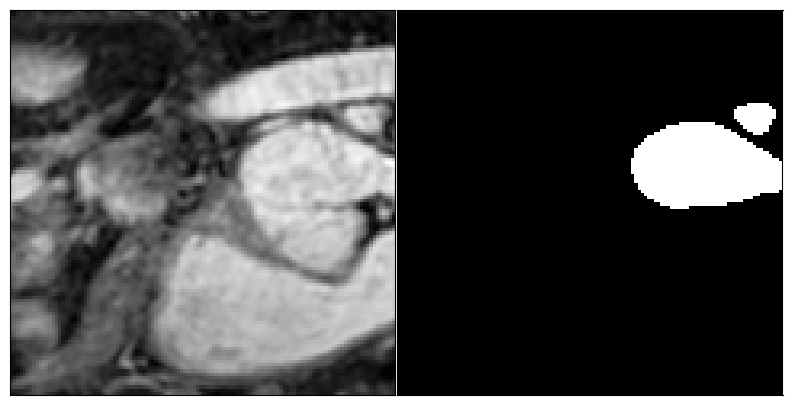


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [116]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import keras
from keras.layers import Reshape

from keras.utils import to_categorical
import cv2
import imageio
from IPython.display import Image,display, HTML
import tensorflow
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose , concatenate, Activation, UpSampling3D,LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.regularizers import l2
import tensorflow as tf



In [330]:
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

HOME_DIR = "Task02_Heart"
DATA_DIR = HOME_DIR

def load_case(image_nifty_file, label_nifty_file):
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    return image, label

def get_labeled_image(image, label):
    image = cv2.normalize(image, None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

    labeled_image = np.zeros((*image.shape, 1), dtype=np.uint8)
    labeled_image[..., 0] = image

    atrium_intensity = 255

    mask = (label == 1)

    labeled_image[mask] = atrium_intensity

    return labeled_image

def get_not_labeled_image(image, label):
    image = cv2.normalize(image, None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

    labeled_image = np.zeros((*image.shape, 1), dtype=np.uint8)
    labeled_image[..., 0] = image

    non_atrium_intensity = 0

    mask = (label == 1)


    return labeled_image

def plot_image(image_with_labels, slice_idx=0):
    """
    Plots a single 2D slice of the image with labels overlaid.

    Parameters:
        image_with_labels (numpy array): The image with labels already overlaid (single-channel).
        slice_idx (int): The index of the slice to plot.
    """
    plt.imshow(image_with_labels[:, :, slice_idx], cmap='gray', interpolation='none')

    plt.title(f'Labeled Image Slice {slice_idx}')
    plt.axis('off')

    plt.show()

def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        img = data_[i, :, :]
        images.append(img)
    imageio.mimsave("/tmp/gif.gif", images, duration=0.01)
    return Image(filename="/tmp/gif.gif", format='png')



In [118]:
image, label = load_case(DATA_DIR + "/imagesTr/la_003.nii.gz", DATA_DIR + "/labelsTr/la_003.nii.gz")
image_label = get_labeled_image(image, label)
image = get_not_labeled_image(image, label)
print(label.shape)

(320, 320, 130)


In [253]:
def get_sub_volume(image, label,
                   orig_x=320, orig_y=320, orig_z=130,
                   output_x=128, output_y=128, output_z=10,
                   num_classes=2, max_tries=5000,
                   background_threshold=0.94):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label of shape (orig_x, orig_y, orig_z)
        orig_x, orig_y, orig_z (int): dimensions of input image
        output_x, output_y, output_z (int): dimensions of output sub-volume
        num_classes (int): number of class labels
        max_tries (int): maximum trials for sampling
        background_threshold (float): threshold for the fraction of background allowed

    Returns:
        X (np.array): extracted sub-volume of shape (num_channels, output_x, output_y, output_z)
        y (np.array): labels corresponding to X, of shape (num_classes, output_x, output_y, output_z)
    """

    tries = 0

    while tries < max_tries:
        start_x = np.random.randint(0, orig_x - output_x + 1)
        start_y = np.random.randint(0, orig_y - output_y + 1)
        start_z = np.random.randint(0, orig_z - output_z + 1)

        y = label[start_x:start_x + output_x,
                  start_y:start_y + output_y,
                  start_z:start_z + output_z]

        y_one_hot = keras.utils.to_categorical(y, num_classes=num_classes)

        background_pixels = np.sum(y == 0)
        total_pixels = y.size
        if total_pixels > 0:
            background_ratio = background_pixels / total_pixels
        else:
            background_ratio = 0


        if background_ratio <= background_threshold:
            X = np.copy(image[start_x:start_x + output_x,
                              start_y:start_y + output_y,
                              start_z:start_z + output_z, :])

            X = np.moveaxis(X, 3, 0)
            y_one_hot = np.moveaxis(y_one_hot, 3, 0)
            y_one_hot = y_one_hot[1:, :, :, :]
            return X, y_one_hot

        tries += 1

    print(f"Tried {tries} times to find a sub-volume. Giving up...")
    return None, None


In [254]:
def visualize_patch(X, y,slices = 0):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, slices], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, slices], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

X shape: (1, 128, 128, 10)
y shape: (1, 128, 128, 10)


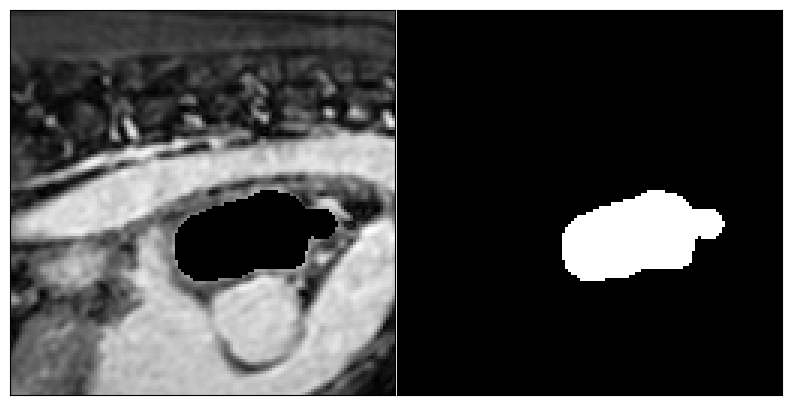

In [256]:
X, y = get_sub_volume(image, label)

if X is not None:
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    visualize_patch(X[0, :, :, :], y[0, :, :, :], 8)


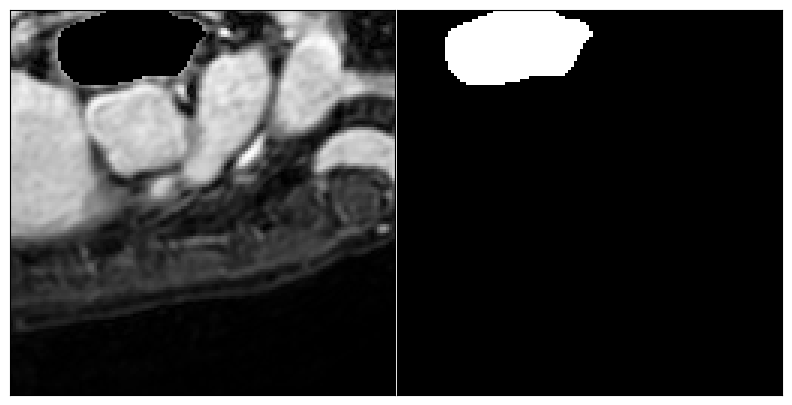

In [122]:
visualize_patch(X[0, :, :], y[0,:,:],slices=20)

In [257]:
def standardize(image):
    """
    Standardize mean and standard deviation
        of each channel and z_dimension.

    Args:
        image (np.array): input image,
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """


    standardized_image = np.zeros((image.shape))

    for c in range(image.shape[0]):
        for z in range(image.shape[3]):
            image_slice = image[c,:,:,z]

            centered = image_slice - image_slice.mean()

            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)
            else:
                centered_scaled = centered
            standardized_image[c, :, :, z] = centered_scaled


    return standardized_image

In [258]:
imagem_normalizada = standardize(X)
print(imagem_normalizada.mean(axis=(1,2,3)))
print(imagem_normalizada.std(axis=(1,2,3)))

[-4.99600361e-17]
[1.]


In [125]:
y[0].shape

(128, 128, 32)

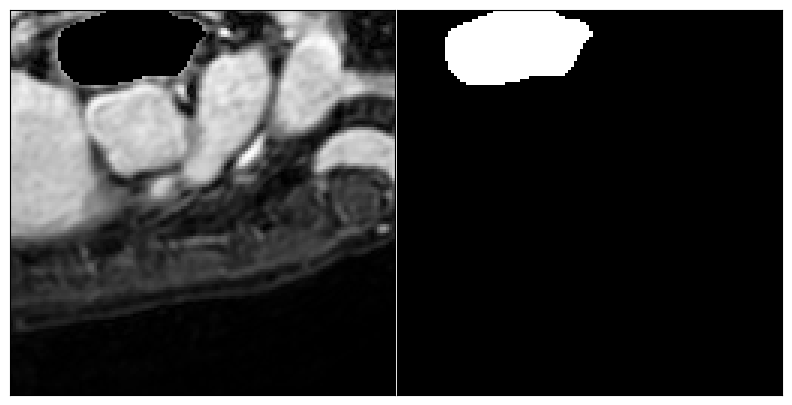

In [126]:
visualize_patch(imagem_normalizada[0, :, :], y[0],20)

In [262]:
x_l, y_l = get_sub_volume(image_label, label)


In [263]:
y_l.shape

(1, 128, 128, 10)

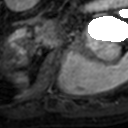

In [128]:
def plot_all_slices(image):
    num_slices = image.shape[-1]
    images = []

    for slice_idx in range(num_slices):
        images.append(image[:, :, slice_idx])

    imageio.mimsave("all_slices.gif", images, duration=0.1)
    display(Image(filename="all_slices.gif"))

plot_all_slices(x_l[0, :, :, :])


In [425]:
def soft_dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.squeeze(y_true, axis=1)
    y_pred = tf.squeeze(y_pred, axis=1)

    dice_numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2]) + smooth
    dice_denominator = tf.reduce_sum(y_true, axis=[0, 1, 2]) + tf.reduce_sum(y_pred, axis=[0, 1, 2]) + smooth

    dice_coefficients = dice_numerator / dice_denominator

    return 1 - tf.reduce_mean(dice_coefficients)




(1, 128, 128, 10)

In [260]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    """
    Compute mean dice coefficient over all abnormality classes.
    """
    if y_true.dtype != y_pred.dtype:
        y_pred = tf.cast(y_pred, y_true.dtype)
   # y_pred = tf.transpose(y_pred, perm=[0, 4,2, 3, 1])  # Transpose to (batch_size, num_labels, x, y, z)


    dice_numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) + epsilon

    dice_coefficient = tf.reduce_mean(dice_numerator / dice_denominator)

    return dice_coefficient


In [264]:
x_l.shape

(1, 128, 128, 10)

In [426]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers

def double_convolution(inputs, num_filters, dropout_rate=0.3):
    x = layers.Conv3D(num_filters, (3, 3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.Conv3D(num_filters, (3, 3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def crop_and_concat(skip_connection, upsampled):
    """
    Crops the skip connection to match the shape of the upsampled layer.
    """
    return layers.concatenate([skip_connection, upsampled], axis=-1)

def build_unet(input_shape=(1, 128, 128, 10)):
    inputs = layers.Input(input_shape)

    conv1 = double_convolution(inputs, 64)
    pool1 = layers.MaxPooling3D((1, 2, 2))(conv1)

    conv2 = double_convolution(pool1, 128)
    pool2 = layers.MaxPooling3D((1, 2, 2))(conv2)

    conv3 = double_convolution(pool2, 256)
    pool3 = layers.MaxPooling3D((1, 2, 2))(conv3)

    conv4 = double_convolution(pool3, 512)
    pool4 = layers.MaxPooling3D((1, 2, 2))(conv4)

    conv5 = double_convolution(pool4, 1024)

    up6 = layers.Conv3DTranspose(512, (2, 2, 2), strides=(1, 2, 2), padding='same')(conv5)
    merge6 = crop_and_concat(conv4, up6)
    conv6 = double_convolution(merge6, 512)

    up7 = layers.Conv3DTranspose(256, (2, 2, 2), strides=(1, 2, 2), padding='same')(conv6)
    merge7 = crop_and_concat(conv3, up7)
    conv7 = double_convolution(merge7, 256)

    up8 = layers.Conv3DTranspose(128, (2, 2, 2), strides=(1, 2, 2), padding='same')(conv7)
    merge8 = crop_and_concat(conv2, up8)
    conv8 = double_convolution(merge8, 128)

    up9 = layers.Conv3DTranspose(64, (2, 2, 2), strides=(1, 2, 2), padding='same')(conv8)
    merge9 = crop_and_concat(conv1, up9)
    conv9 = double_convolution(merge9, 64)

    outputs = layers.Conv3D(input_shape[-1], (1, 1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model




In [427]:
unet_model = build_unet()


In [445]:
unet_model.compile(optimizer=Adam(learning_rate=0.001), loss=soft_dice_loss, metrics=[dice_coefficient])
unet_model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 1, 128, 128,    │              0 │ -                      │
│ (InputLayer)              │ 10)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_420 (Conv3D)       │ (None, 1, 128, 128,    │         17,344 │ input_layer_36[0][0]   │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_421 (Conv3D)       │ (None, 1, 128, 128,    │        110,656 │ conv3d_420[0][0]       │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 1, 128, 128,    │              0 │ conv3d_421[0][0]       │
│                           │ 64)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_106         │ (None, 1, 64, 64, 64)  │              0 │ dropout_31[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_422 (Conv3D)       │ (None, 1, 64, 64, 128) │        221,312 │ max_pooling3d_106[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_423 (Conv3D)       │ (None, 1, 64, 64, 128) │        442,496 │ conv3d_422[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 1, 64, 64, 128) │              0 │ conv3d_423[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_107         │ (None, 1, 32, 32, 128) │              0 │ dropout_32[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_424 (Conv3D)       │ (None, 1, 32, 32, 256) │        884,992 │ max_pooling3d_107[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_425 (Conv3D)       │ (None, 1, 32, 32, 256) │      1,769,728 │ conv3d_424[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 1, 32, 32, 256) │              0 │ conv3d_425[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_108         │ (None, 1, 16, 16, 256) │              0 │ dropout_33[0][0]       │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_426 (Conv3D)       │ (None, 1, 16, 16, 512) │      3,539,456 │ max_pooling3d_108[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_427 (Conv3D)       │ (None, 1, 16, 16, 512) │      7,078,400 │ conv3d_426[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 1, 16, 16, 512) │              0 │ conv3d_427[0][0]       │
├──────────────────────

 Total params: 90,308,810 (344.50 MB)

 Trainable params: 90,308,810 (344.50 MB)

 Non-trainable params: 0 (0.00 B)

In [440]:
class VolumeDataGenerator(keras.utils.Sequence):
    def __init__(self,
                 sample_list,
                 base_dir,
                 batch_size=2,
                 shuffle=True,
                 dim=(128, 128, 10),
                 num_channels=1,
                 num_classes=2,
                 verbose=1):

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.dim = dim
        self.training_dir = "/imagesTr/"
        self.label_dir = "/labelsTr/"
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.verbose = verbose
        self.sample_list = sample_list
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.sample_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.sample_list) / self.batch_size))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'

        X = np.zeros((self.batch_size, self.num_channels, *self.dim),
                     dtype=np.float64)
        y = np.zeros((self.batch_size, self.num_classes - 1, *self.dim),
                     dtype=np.float64)

        for i, ID in enumerate(list_IDs_temp):

            if self.verbose == 1:
                a,b= load_case(self.base_dir + self.training_dir + ID ,self.base_dir +self.label_dir + ID)
                a = get_not_labeled_image(a,b)
                X_temp, y_temp = get_sub_volume(a,b)


                if X_temp is not None and y_temp is not None:

                    if X_temp.shape[-1] < self.dim[-1]:
                      padding = np.zeros((X_temp.shape[0], X_temp.shape[1], X_temp.shape[2], self.dim[-1]- X_temp.shape[-1]))
                      X_temp = np.concatenate((X_temp, padding), axis=-1)
                      padding = np.zeros((y_temp.shape[0], y_temp.shape[1], y_temp.shape[2], self.dim[-1] - y_temp.shape[-1]))

                      y_temp = np.concatenate((y_temp, padding), axis=-1)
                    X[i] = X_temp
                    X[i] = standardize(X[i])
                    y[i] = y_temp
                else:
                    print(f"Warning: No valid sub-volume found for ID {ID}. Using empty arrays.")
                    X[i] = np.zeros((self.num_channels, *self.dim), dtype=np.float64)
                    y[i] = np.zeros((self.num_classes, *self.dim), dtype=np.float64)

            else:
                a,b= load_case(self.base_dir + self.training_dir + ID ,self.base_dir +self.label_dir + ID)

                a = get_not_labeled_image(a,b)

                X_temp, y_temp = get_sub_volume(a,b)

                if X_temp is not None and y_temp is not None:

                    if X_temp.shape[-1] < self.dim[-1]:
                      padding = np.zeros((X_temp.shape[0], X_temp.shape[1], X_temp.shape[2], self.dim[-1] - X_temp.shape[-1]))
                      X_temp = np.concatenate((X_temp, padding), axis=-1)
                      padding = np.zeros((y_temp.shape[0], y_temp.shape[1], y_temp.shape[2], self.dim[-1] - y_temp.shape[-1]))

                      y_temp = np.concatenate((y_temp, padding), axis=-1)
                    X[i] = X_temp
                    X[i] = standardize(X[i])

                    y[i] = y_temp
                else:
                    print(f"Warning: No valid sub-volume found for ID {ID}. Using empty arrays.")
                    X[i] = np.zeros((self.num_channels, *self.dim), dtype=np.float64)
                    y[i] = np.zeros((self.num_classes, *self.dim), dtype=np.float64)

        return X, y

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[
                  index * self.batch_size: (index + 1) * self.batch_size]
        sample_list_temp = [self.sample_list[k] for k in indexes]
        X, y = self.__data_generation(sample_list_temp)

        return X, y



In [441]:
import os

def create_file_list(directory):
  """
  Creates a list of file names within a directory.

  Args:
    directory: The directory to search for files.

  Returns:
    A list of file names.
  """
  file_list = []
  for filename in os.listdir(directory):
    if filename.endswith(".nii.gz"):
      for x in range(5):
        file_list.append(filename)

  return file_list


HOME_DIR = "Task02_Heart"

imagesTr_directory = os.path.join(HOME_DIR, "imagesTr")
file_list = create_file_list(imagesTr_directory)

split_index = int(0.8 * len(file_list))
train_list = file_list[:split_index]
validation_list = file_list[split_index:]


for x in range(len(train_list)):
      train_list[x] = train_list[x].replace("._","")


for x in range(len(validation_list)):
      validation_list[x] = validation_list[x].replace("._","")

import random
random.shuffle(train_list)
random.shuffle(validation_list)
print("Train list:", train_list)
print("Validation list:", validation_list)


Train list: ['la_024.nii.gz', 'la_020.nii.gz', 'la_023.nii.gz', 'la_007.nii.gz', 'la_003.nii.gz', 'la_018.nii.gz', 'la_016.nii.gz', 'la_024.nii.gz', 'la_018.nii.gz', 'la_005.nii.gz', 'la_017.nii.gz', 'la_016.nii.gz', 'la_014.nii.gz', 'la_018.nii.gz', 'la_009.nii.gz', 'la_010.nii.gz', 'la_010.nii.gz', 'la_005.nii.gz', 'la_011.nii.gz', 'la_005.nii.gz', 'la_024.nii.gz', 'la_004.nii.gz', 'la_007.nii.gz', 'la_020.nii.gz', 'la_009.nii.gz', 'la_003.nii.gz', 'la_009.nii.gz', 'la_020.nii.gz', 'la_021.nii.gz', 'la_020.nii.gz', 'la_021.nii.gz', 'la_004.nii.gz', 'la_022.nii.gz', 'la_004.nii.gz', 'la_023.nii.gz', 'la_022.nii.gz', 'la_023.nii.gz', 'la_010.nii.gz', 'la_011.nii.gz', 'la_014.nii.gz', 'la_017.nii.gz', 'la_007.nii.gz', 'la_009.nii.gz', 'la_004.nii.gz', 'la_009.nii.gz', 'la_003.nii.gz', 'la_014.nii.gz', 'la_020.nii.gz', 'la_021.nii.gz', 'la_011.nii.gz', 'la_021.nii.gz', 'la_004.nii.gz', 'la_010.nii.gz', 'la_024.nii.gz', 'la_003.nii.gz', 'la_023.nii.gz', 'la_016.nii.gz', 'la_018.nii.gz', '

In [361]:
len(train_list)

84

In [446]:
train_generator = VolumeDataGenerator(
    sample_list=train_list,

    base_dir=HOME_DIR,
    batch_size=2,
    shuffle=True,
    dim=(128, 128, 10),
    num_channels=1,
    num_classes=2,
    verbose=1
)

validation_generator = VolumeDataGenerator(
    sample_list=validation_list,
    base_dir=HOME_DIR,
    batch_size=2,
    shuffle=False,
    dim=(128, 128, 10),
    num_channels=1,
    num_classes=2,
      verbose=1
)


In [447]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [448]:
y.shape

(1, 128, 128, 10)

In [449]:
history = unet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1,
    callbacks=[reduce_lr,early_stopping]
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - dice_coefficient: 0.0297 - loss: 1.0245 - val_dice_coefficient: 0.0056 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - dice_coefficient: 0.1692 - loss: 0.7831 - val_dice_coefficient: 0.7792 - val_loss: 0.4210 - learning_rate: 0.0010
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - dice_coefficient: 0.4904 - loss: 0.7573 - val_dice_coefficient: 0.7000 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - dice_coefficient: 0.4124 - loss: 0.8940 - val_dice_coefficient: 0.6500 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coefficient: 0.3408 - loss: 0.8960
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - dice_coefficient: 0.3412 - loss: 0.8952 - val_dice_coefficient: 0.6780 - val_loss: 0.4768 - learning_rate: 0.0010
Epoch 6/3

In [528]:
unet_model.save('melhor_modelo_segmentacao.h5')
from google.colab import files

files.download('melhor_modelo_segmentacao.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [470]:
image_test,label= load_case(DATA_DIR + "/imagesTr/la_003.nii.gz",DATA_DIR + "/labelsTr/la_003.nii.gz")
image= get_not_labeled_image(image_test,label)

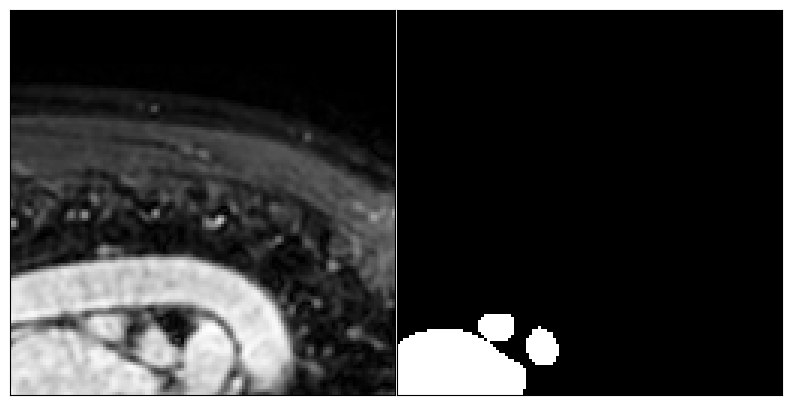

In [471]:
X, y = get_sub_volume(image, label)

visualize_patch(X[0, :, :], y[0])

In [521]:
X_with_batch_dimension = np.expand_dims(X, axis=0)
patch_pred = unet_model.predict(X_with_batch_dimension)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


In [509]:
X_with_batch_dimension.shape

(1, 1, 128, 128, 10)

In [522]:

import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_pred):
  """
  Finds the best threshold for binary classification based on F1 score.

  Args:
    y_true: True labels (ground truth).
    y_pred: Predicted probabilities or scores.

  Returns:
    The best threshold.
  """
  best_threshold = 0
  best_f1 = 0

  for threshold in np.arange(0.1, 1.0, 0.01):
    y_pred_binary = (y_pred > threshold).astype(int)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten())
    if f1 > best_f1:
      best_f1 = f1
      best_threshold = threshold

  return best_threshold

y_true_flattened = y.flatten()
y_pred_flattened = patch_pred.flatten()

best_threshold = find_best_threshold(y_true_flattened, y_pred_flattened)

print("Best threshold:", best_threshold)


Best threshold: 0.9899999999999995


In [523]:
patch_pred[patch_pred > best_threshold] = 1.0
patch_pred[patch_pred <= best_threshold] = 0.0

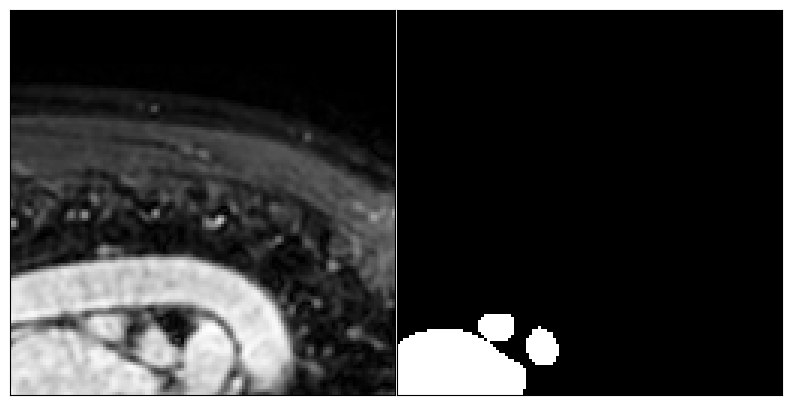

Patch and prediction


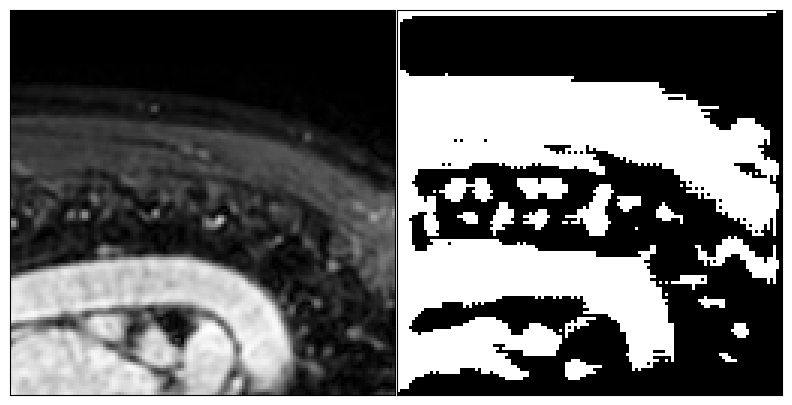

In [526]:
for sliced in range(1):
    visualize_patch(X_with_batch_dimension[0, 0, :,:,], y[0],sliced)
    plt.show()
    print("Patch and prediction")

    visualize_patch(X_with_batch_dimension[0, 0, :,:,], patch_pred[0][0],sliced)
    plt.show()

### Resultados Finais

Coeficiente Dice Treino: 0.3950
Coeficiente Dice Treino: 0.7248

Não tão eficiente, talvez aumentar a profundidade e modificar a arquitetura para absorver mais dados eficientemente (e evitar dimensões negativas).

Além disso, Data Augmentation pode se provar eficiente porém alterações como rotação pode vir a não ser benéfico para o treino do modelo.

Batch Size com uma maior quantidade de elementos não se provou eficiente no treino, resultando em perdas crescentes e um coeficiente dice tendendo à zero a medida que as épocas passavam.

Um outro motivo para o mal aprendizado do modelo é por conta dos próprios dados, o átrio esquerdo compõe uma pequena parcela do MRI e não foi possível em muitos casos encontrar sub-volumes com uma quantidade significativa de fatias que contenham pelo menos 10% dos píxeis como sendo parte do átrio esquerdo. Somente foi achado com mais abundância sub-volumes com pelo menos 3% dos píxeis como sendo parte do átrio esquerdo, dificultando muito o aprendizado do modelo.


Note ainda que, mesmo não eficiente, a segmentação captou alguns dados interessantes, parecendo no final associar pontos com maior claridade à pertencer ao átrio esquerdo, o que obviamente não é correto, porém é um passo mais perto de um modelo que consegue captar de forma eficiente o átrio esquerdo.